In [1]:
import time
import casadi
import numpy as np
from utils.RobotConfig import RobotConfig
from utils.Lagrange import *
from utils.LGL_collocation import LGL_collocation
from utils.LocalChart import *
import pinocchio as pin
from pinocchio import casadi as cpin
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
import scipy

In [2]:
Ntp = 10     # Number of collocation points / basis (degree: Ntp-1)

### Robot Model

In [3]:
config_file = 'config/SimpleConfig.yaml'
q_waypoints = np.array([[0, np.pi/4, 0, 0, 0, 0], 
                    [-np.pi/6, np.pi/12, np.pi/6, -np.pi/6, -np.pi/3, -np.pi/3],
                    [-np.pi/4, np.pi/4, np.pi/3, 0, -np.pi/6, -np.pi/2]])

Robot = RobotConfig(config_file)
Robot.lowerVelocityLimit = np.pi/2 * np.array([-1, -1, -1, -1, -1, -1])  # rad/s
Robot.upperVelocityLimit = np.pi/2 * np.array([1, 1, 1, 1, 1, 1])
Robot.lowerTorqueLimit = 100 * np.array([-1, -1, -1, -1, -1, -1]) 
Robot.upperTorqueLimit = 100 * np.array([1, 1, 1, 1, 1, 1])


ngc = Robot.model.nq   # Number of joints
ngc = Robot.model.nv   # Number of DOF
nx = 2*ngc    # Number of states
cx = casadi.SX.sym("x", nx, 1)
ctau = casadi.SX.sym("tau", ngc, 1)
cacc = cpin.aba(Robot.cmodel, Robot.cdata, cx[:ngc], cx[ngc:], ctau) # Forward dynamics


q0 = q_waypoints[0]
qT = q_waypoints[-1]
tau0 = pin.rnea(Robot.model, Robot.data, q0, np.zeros(ngc), np.zeros(ngc))
tauT = pin.rnea(Robot.model, Robot.data, qT, np.zeros(ngc), np.zeros(ngc))
print(tau0)
print(tauT)

[  0.         -36.08572402  -9.26563407   0.97299901  -0.09997149
   0.        ]
[ 8.88178420e-16 -2.17616448e+01  5.05844512e+00  1.31084531e+00
 -1.18267539e-01  0.00000000e+00]


### Gauss–Legendre Collocation

In [4]:
Np = q_waypoints.shape[0]-1  # Number of phase (dersired waypoints: N+1)
T = Np*Ntp  # Number of total collocation points / optimization variables

LGL_Pts, LGL_Wts = Normalize_LGL_Pts_Wts(Ntp)
DL,_ = differentiation_matrix(Ntp, LGL_Pts)

LGL = LGL_collocation(Ntp, ngc, ngc)
StatesDiff, StateDiff, LocalsDiff, LocalDiff= LGL.getDiffFuncs()

Feq = casadi.Function(
    "Dyn",
    [cx, ctau],
    [casadi.vertcat(cx[ngc:], cacc)],
)

### Nonlinear Programming Problem (NLP)

In [5]:
opti = casadi.Opti()
# Optimization variables
var_xs = [opti.variable(nx) for _ in range(T)]
var_us = [opti.variable(ngc) for _ in range(T)]
var_deltaT = [opti.variable(1) for _ in range(Np)]

In [6]:
# Constraints
for i in range(Np):
    opti.subject_to(var_deltaT[i] >= 0.0)

    for tp in range(Ntp):
        t = i*Ntp + tp
        # dynamics
        opti.subject_to(StatesDiff(casadi.vertcat(*var_xs[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[tp,:]) 
                        == Feq(var_xs[t], var_us[t]))
        
        # joint constraints
        opti.subject_to(var_xs[t][:ngc] <= Robot.upperPositionLimit)
        opti.subject_to(var_xs[t][:ngc] >= Robot.lowerPositionLimit)
        # joint velocity constraints
        opti.subject_to(var_xs[t][ngc:] <= Robot.upperVelocityLimit)
        opti.subject_to(var_xs[t][ngc:] >= Robot.lowerVelocityLimit)
        # torque constraints
        opti.subject_to(var_us[t] <= Robot.upperTorqueLimit)
        opti.subject_to(var_us[t] >= Robot.lowerTorqueLimit)

# waypoints constraints (N-1 middle waypoints)
for i in range(1, Np):
    opti.subject_to(var_xs[i*Ntp][:ngc] == q_waypoints[i])

# continuity
for i in range(1, Np):
    opti.subject_to(var_xs[i*Ntp-1] == var_xs[i*Ntp])
    opti.subject_to(var_us[i*Ntp-1] == var_us[i*Ntp])

# continuity of derivatives
for i in range(Np-1):
    opti.subject_to(StatesDiff(casadi.vertcat(*var_xs[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[Ntp-1,:]) 
                    == StatesDiff(casadi.vertcat(*var_xs[(i+1)*Ntp: (i+2)*Ntp]), var_deltaT[i+1], DL[0,:]))

    opti.subject_to(LocalDiff(casadi.vertcat(*var_us[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[Ntp-1,:])
                   == LocalDiff(casadi.vertcat(*var_us[(i+1)*Ntp: (i+2)*Ntp]), var_deltaT[i], DL[0,:]))

# boundary conditions
opti.subject_to(var_xs[0][:ngc] == q0)
opti.subject_to(var_xs[-1][:ngc] == qT)
opti.subject_to(var_xs[0][ngc:] == 0)
opti.subject_to(var_xs[-1][ngc:] == 0)
#opti.subject_to(var_us[0] == tau0)
#opti.subject_to(var_us[-1] == tauT)

# Objective
totalcost = 0

R = np.eye(ngc)
for i in range(Np):
    for tp in range(Ntp):
        var_xs_Phase = var_xs[i*Ntp: (i+1)*Ntp]
        dq = [dq_Phase[ngc:] for dq_Phase in var_xs_Phase]
        ddq = StateDiff(casadi.vertcat(*dq), var_deltaT[i], DL[tp,:])
        totalcost += var_deltaT[i]/2 * LGL_Wts[tp] * casadi.mtimes([ddq.T, R, ddq])
        
    totalcost += var_deltaT[i]

opti.minimize(totalcost)
opti.solver("ipopt") 

for x in var_xs:
    opti.set_initial(x, np.concatenate([q0, np.zeros(ngc)]))
for u in var_us:
    opti.set_initial(u, tau0)
for t in var_deltaT:
    opti.set_initial(t, 2)


In [7]:
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_us = [opti.value(var_u) for var_u in var_us]
    sol_T = [opti.value(var_t) for var_t in var_deltaT]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_us = [opti.debug.value(var_u) for var_u in var_us]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:     5256
Number of nonzeros in inequality constraint Jacobian.:      722
Number of nonzeros in Lagrangian Hessian.............:     5882

Total number of variables............................:      362
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      306
Total number of inequality c

In [8]:
print(sol_T)
print(f"Total time: {sum(sol_T)}")

T_List = [0] + [sum(sol_T[:i+1]) for i in range(Np)]

[2.992504473066526, 2.382264572973701]
Total time: 5.374769046040226


In [9]:
### Check collision
from utils.ObstacleSpheres import ObsConfig

obs = ObsConfig(config_file)
obs.spheres_from_robot(q0 = q_waypoints[0].astype(float).tolist())  # Get initial robot obstacle spheres
obs.spheres_from_env()

cq = casadi.SX.sym('q', ngc)
get_obstacle_distances = casadi.Function(
    'get_obstacle_distances', 
    [cq], 
    [casadi.vertcat(*Robot.obstacle_distances(cq, obs.env_spheres, obs.robot_spheres))]
    )

for t in range(T):
    dis = np.min(np.array(get_obstacle_distances(sol_xs[t][:ngc])))
    print(f"Collision Distance {t}: {dis}, \n State:{Robot.collision_status(sol_xs[t][:ngc], obs.env_spheres, obs.robot_spheres)}")


Collision Distance 0: 0.006613313039108972, 
 State:False
Collision Distance 1: 0.006350328220162555, 
 State:False
Collision Distance 2: 0.0027771874514950588, 
 State:False
Collision Distance 3: -0.004589730872164421, 
 State:True
Collision Distance 4: -0.005532600347718439, 
 State:True
Collision Distance 5: 0.0027598988454181402, 
 State:False
Collision Distance 6: 0.0011488522970671908, 
 State:False
Collision Distance 7: 0.008975423916876252, 
 State:False
Collision Distance 8: 0.015766852069752604, 
 State:False
Collision Distance 9: 0.018832358213584113, 
 State:False
Collision Distance 10: 0.018832358213584102, 
 State:False
Collision Distance 11: 0.021402313117629277, 
 State:False
Collision Distance 12: 0.008151352785358796, 
 State:False
Collision Distance 13: -0.005638274671965326, 
 State:True
Collision Distance 14: -0.005250889548666288, 
 State:True
Collision Distance 15: 0.004659268261138069, 
 State:False
Collision Distance 16: 0.022329796349211208, 
 State:False
Coll

### Inverse dynamics


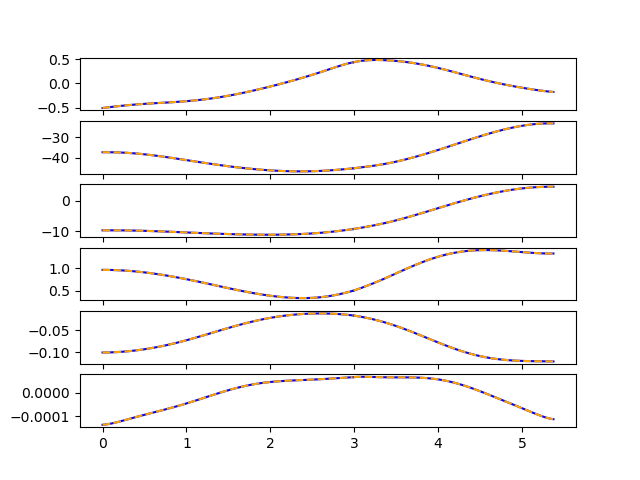

In [10]:
nsample = 100
fig1, axs1 = plt.subplots(ngc,1)

t = casadi.SX.sym("t")
for i in range(Np):
    sample_t = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]

    inter_xs = casadi.Function(
        "xt", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )
    inter_us = casadi.Function(
        "ut", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_us[i*Ntp: (i+1)*Ntp])]
    )
    inter_dxs = casadi.Function(
        "dxt", 
        [t], [DiffLangrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )


    sample_q = np.array([np.squeeze(inter_xs(ti)[:ngc]) for ti in sample_t])
    sample_dq = np.array([np.squeeze(inter_xs(ti)[ngc:]) for ti in sample_t])
    sample_ddq = np.array([np.squeeze(inter_dxs(ti)[ngc:]) for ti in sample_t])

    # from interpolation
    sample_u = np.array([np.squeeze(inter_us(ti)) for ti in sample_t])
    
    # from dynamics equations
    tau_id = np.array([pin.rnea(Robot.model, Robot.data, q, dq, ddq) for q, dq, ddq in zip(sample_q, sample_dq, sample_ddq)])
    
    joint_traj = np.concatenate((joint_traj, sample_q), axis=0) if i > 0 else sample_q

    # plot sample_u and tau
    for j in range(ngc): 
        axs1[j].plot(sample_t, sample_u[:,j], label=f'u{j}',color='blue')
        axs1[j].plot(sample_t, tau_id[:,j], label=f'tau{j}',color='orange',linestyle='dashed')
plt.show()

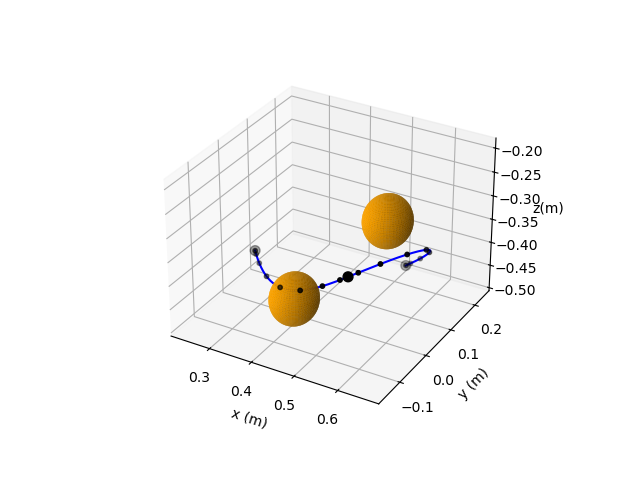

In [11]:
from visualization.plotGeo import *
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

'''
for t in range(T):
    if Robot.collision_status(sol_xs[t][:ngc], obs.env_spheres, obs.robot_spheres) == True:
        sphere_list = Robot.update_robot_spheres(obs.robot_spheres,joint_traj[i])
        plot_robot_spheres(ax, sphere_list, color='purple',alpha=0.5)
        print(t)
        break
'''

tool_traj = np.zeros((joint_traj.shape[0], 3))
for i in range(joint_traj.shape[0]):
    _, _, p = Robot.forward_kinematics(joint_traj[i])
    tool_traj[i] = p


tool_collocation_points = np.zeros((T, 3))
for i in range(T):
    _, _, p = Robot.forward_kinematics(np.array(sol_xs[i][:ngc]))
    tool_collocation_points[i] = p

tool_waypoints = np.zeros((q_waypoints.shape[0], 3))
for i in range(q_waypoints.shape[0]):
    _, _, p = Robot.forward_kinematics(q_waypoints[i])
    tool_waypoints[i] = p


plot_traj(ax, tool_traj, color='blue', axis_label=['x (m)','y (m)','z(m)'])
plot_points(ax, tool_collocation_points, color = 'black', s = 10)
plot_points(ax, tool_waypoints, color='black', s =50)
plot_env_spheres(ax, obs.env_spheres, color='orange',alpha=1)
plt.show()

3


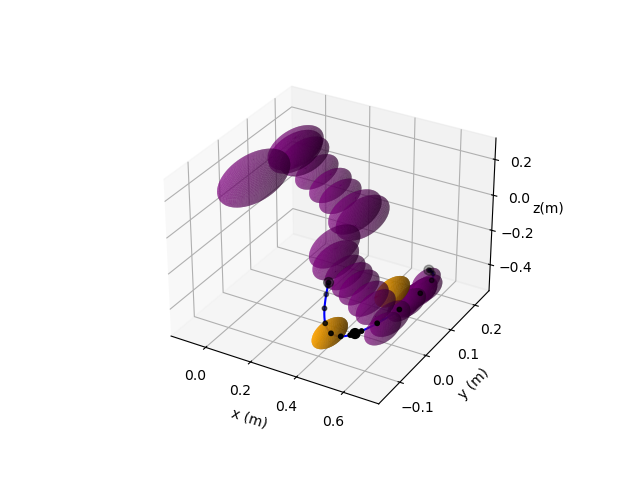

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for t in range(T):
    if Robot.collision_status(sol_xs[t][:ngc], obs.env_spheres, obs.robot_spheres) == True:
        sphere_list = Robot.update_robot_spheres(obs.robot_spheres,sol_xs[t][:ngc])
        plot_robot_spheres(ax, sphere_list, color='purple',alpha=0.5)
        print(t)
        break


tool_traj = np.zeros((joint_traj.shape[0], 3))
for i in range(joint_traj.shape[0]):
    _, _, p = Robot.forward_kinematics(joint_traj[i])
    tool_traj[i] = p


tool_collocation_points = np.zeros((T, 3))
for i in range(T):
    _, _, p = Robot.forward_kinematics(np.array(sol_xs[i][:ngc]))
    tool_collocation_points[i] = p

tool_waypoints = np.zeros((q_waypoints.shape[0], 3))
for i in range(q_waypoints.shape[0]):
    _, _, p = Robot.forward_kinematics(q_waypoints[i])
    tool_waypoints[i] = p


plot_traj(ax, tool_traj, color='blue', axis_label=['x (m)','y (m)','z(m)'])
plot_points(ax, tool_collocation_points, color = 'black', s = 10)
plot_points(ax, tool_waypoints, color='black', s =50)
plot_env_spheres(ax, obs.env_spheres, color='orange',alpha=1)
plt.show()